# Assignment 3 

Project Name: COSC102 - Assignment 3 – Machine Learning Portfolio: Comparing the Performance of Machine Learning Approaches for Activity Classification <br>
Authors: - Andrew Lu, Jessica Vu, Joshua Hahn<br>
Email: - jhahn@myune.edu.au<br>
Date: - 24/08/24<br>

#### WORK IN PROGRESS 

Activity classification is the process of caputuring human movement using certain devices such as Inertial Measurement Unit's (imus) and creating machine learning classification models to be able to tell what type of movement is being performed. It is a common task performed daily by most popular devices like smart watches and phones.

In this project we will be taking two separate datasets, one comprised of x, y, and z points from an imu and the second set being a series of annotated values from a video recording of the same human movements. We will be taking these two dataset:
- Combining them together and aligning their time values
- Calculating a new set of metrics to create a set of features
- Training a series of classifiers on these new features
- Implementing optimization of hyper parameters to fine tune the models
- Creating a series of visualization to show the training decisions and final outcomes
- Concluding on the results we have found





In [1]:
# Import statements, we might not use all these

import math
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

# Joshua Hahn

## Load data

We will begin by loading up our data sets and running through the beginning checklist of any data science project. This includes<br>
inspecting our data sets, checking for missing values and fixing any preliminary probelms we might see before moving onto the steps.

In [2]:
# function to load csv files as pandas dataframe

def load_data(csv, header, col_names):
    """
    Takes a csv's file path in the form of a string and 
    returns a pandas dataframe of the csv, if the dataset
    has no column names, it will append a passed in list
    of column names, otherwise it will leave the dataset 
    as is.
    Params:
    String - csv, string of the file path for a given csv
    header - Paramater deciding if the first row of the csv 
    are the column names or not, pass "infer" if your data
    set has column names and "None" if it doesn't
    names - A list of column names to assign to the dataset
    only if the headers parameter is "None", pass None for
    this parameter if your dataset already has column names.
    Returns:
    Pandas dataframe of a csv file
    """
    return pd.read_csv(csv, header=header, names=col_names)    

In [3]:
# File paths for our csv data sets
IMU_DATA = "./a3_imu_data.csv"
ACTIVITY_DATA = "./a3_activity_annotations.csv"

Looking at the raw csv files outside of the project, we noticed that the imu data set has no column names, we are going to need<br>
to assign the data set column names so that it is easier/possible to work with. The names chosen were taken from the assignments <br>
task sheet. The activity data already had column names assigned and accurate, so no work was neccersary on them.

In [4]:
# Initialing our datasets as pandas dataframes and assigning column names

# List of column namesColumn 
imu_col_names = ["timestamp", "x_axis_accel", "y_axis_accel", "z_axis_accel", "x_axis_gyro", "y_axis_gyro", "z_axis_gyro"]

# Loading our csv files, the imu set has no column names so we are passing in a list of names to add
# The activity dataset comes with names so we leave it as it is and pass in "None" for column names
imu_data_raw = load_data(IMU_DATA, None, imu_col_names)
activity_data_raw = load_data(ACTIVITY_DATA, "infer", None)

That should do the job, now let's look and see what our datasets look like, check for missing values, and plot a basic visualization<br> of the data sets.

In [5]:
# Function to check for any null values

def check_for_null(dataset, name):
    """
    Takes a pandas dataframe and the name of the dataframe as a string and
    checks if there are any missing values in all columns, prints out the 
    results
    Params:
    dataset - A pandas dataframe 
    name - A string for the name of your dataframe
    """
    print(f"{name}'s NULL values \n")
    for col in dataset.columns:
        print(f"{dataset[col].name} has {dataset[col].isnull().sum()} null values")

In [6]:
# Function to display a basic plot of our data

def plot_dataframe(X, y, title):
    """
    Takes an X and y from a pandas dataseries as well as the title in the form of a string. 
    The X value should be a single column of values from a pandas dataframe, the y values
    can contain as many columns as you like.
    Params:
    X - Pandas series containing the x value for our plot
    y - Pandas series containing the y value(s) for our plot
    title - String containing the desired title for our plot
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(18,10))

    # for every column in the y set, get the column name and append it to a list of labels
    
    labels=[i for i in y.columns]

    # Plot the data and add basic quality of life features
    plt.plot(X, y, label= labels)
    ax.set_xlabel(X.name, fontsize=18)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_ylabel("Values", fontsize=18)
    ax.set_title(title, fontsize=22)
    plt.grid()
    plt.legend()

## Visualize the datasets and inspect for alignment errors

### IMU Dataset Inspection

In [7]:
# Check for null values
check_for_null(imu_data_raw, "IMU DATA")


IMU DATA's NULL values 

timestamp has 0 null values
x_axis_accel has 0 null values
y_axis_accel has 0 null values
z_axis_accel has 0 null values
x_axis_gyro has 0 null values
y_axis_gyro has 0 null values
z_axis_gyro has 0 null values


In [8]:
# Get basic information
imu_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71242 entries, 0 to 71241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   timestamp     71242 non-null  int64
 1   x_axis_accel  71242 non-null  int64
 2   y_axis_accel  71242 non-null  int64
 3   z_axis_accel  71242 non-null  int64
 4   x_axis_gyro   71242 non-null  int64
 5   y_axis_gyro   71242 non-null  int64
 6   z_axis_gyro   71242 non-null  int64
dtypes: int64(7)
memory usage: 3.8 MB


In [9]:
# Visualise the dataframe
imu_data_raw.head()

timestamp  x_axis_accel  y_axis_accel  z_axis_accel  x_axis_gyro  \
0  1598240213         -2402          1710          -380        -1413   
1  1598240213         -1880          1688          -420        -1469   
2  1598240213         -1558          1568          -606        -1535   
3  1598240213         -1154          1732          -654        -1293   
4  1598240213          -452          2084          -754         -719   

   y_axis_gyro  z_axis_gyro  
0         -362          223  
1         -597          -23  
2         -872         -195  
3         -976         -335  
4         -940         -214

From above we can see that that our timestamps are calculated as unix time stamps, we might want to convert these to seconds before we plot <br>
the series to avoid some unpretty looking axis values. This will also come in handy later on in this project when aligning the two dataset's. <br>


In [10]:
# Creating a function specifically to convert unix time stamps to seconds

def convert_time_series(data_series):
    """
    Converts a series consisting of unix timestamps to seconds and returns the series
    Params:
    data_series - a pandas dataseries of unix timestamps
    Returns:
    A time series in seconds
    """
    # Assign the timestamp to a variable
    time = data_series

    # Create a starting time outside of our loop so that it doesn't change value
    # as we iterate through each value of the series
    start_time = time[0]
    
    # Iterate through every value of the timestamp column
    for row in time:
        # Get the time in the timstamp column, minus the first value, and plus 1,
        # this will essentially count seconds from the start of the dataseries
        calc_seconds = row - start_time + 1
        # Take the value calculated above and replace it in our time column, this
        # will remove the unix timestamp from the column and replace it with the
        # difference in seconds since the start of the dataseries
        time = time.replace(to_replace=row, value=calc_seconds)
    
    # Add the new time series to our dataframe
    return time

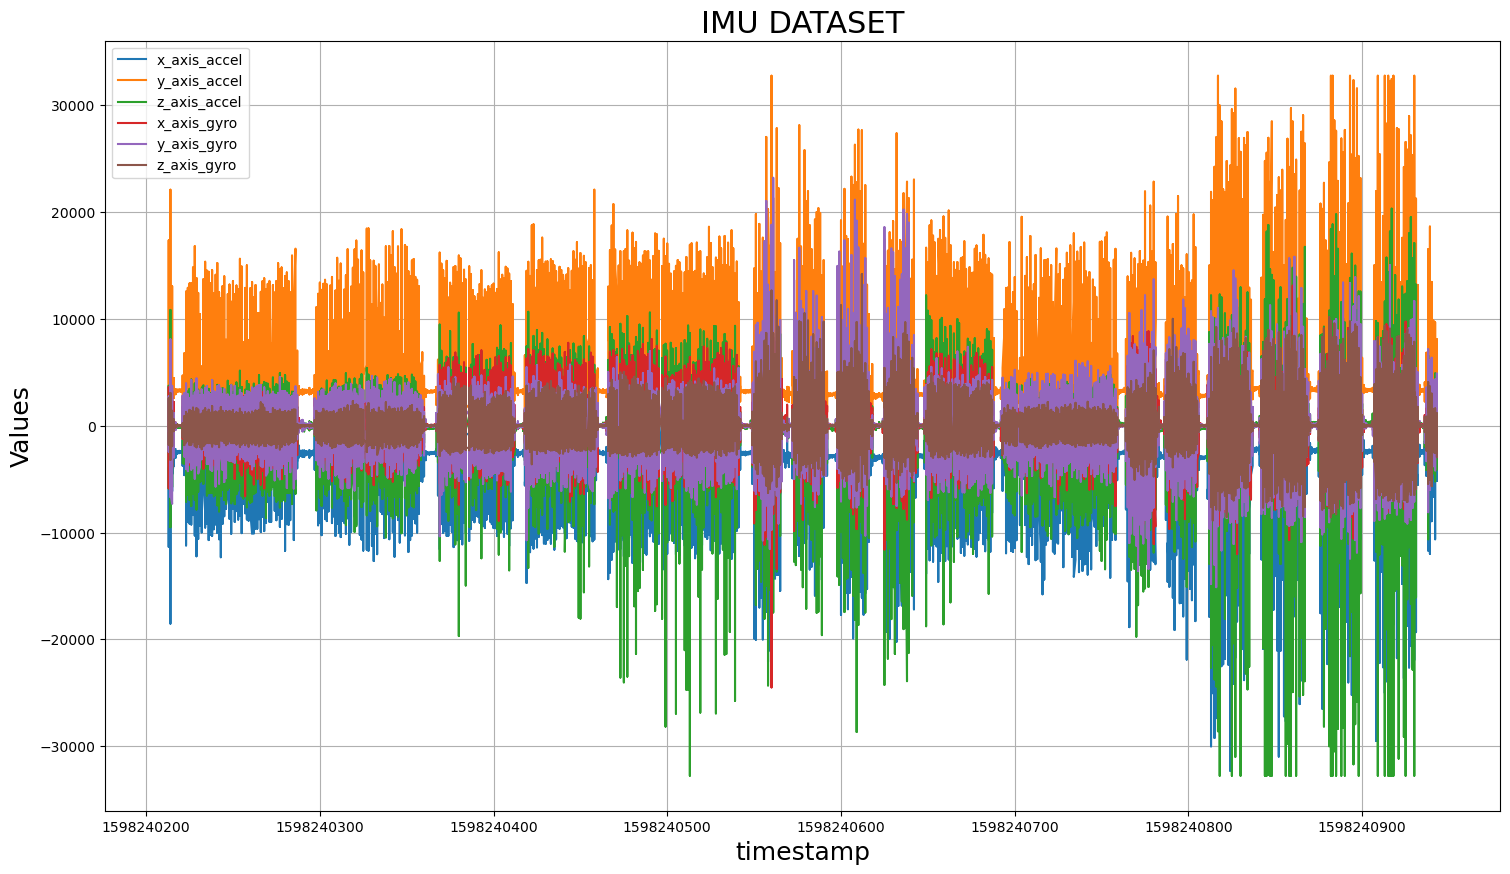

In [11]:
# Call the plot_dataframe function passing it our dataframes timestamp column for the X axis and every other column for our y values

imu_data_raw["time (seconds)"] = convert_time_series(imu_data_raw["timestamp"])

plot_dataframe(imu_data_raw["timestamp"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

By the looks of it, our IMU dataset looks pretty straight forward:
- There are no null values
- We were able to correctly name the columns
- There are 71,000 samples of data
- All data values are integers
- The timestamp are unix time stamps
- We have created a new column value "time (seconds)" <br>
that tracks the time from the start of the data to <br>
any given point in seconds
<br>

One thing that stands out when visualizing this dataset is the start and end points of the data don't really match any other sections of the set, depending on <br>
what our activity data looks like, we may have to slice out these points to align the data more accuratly. Another thing of note is the different sections of<br>
of the dataset. There appears to be 17 different movement sections with 4 or 5 different movement patterns, another thing to look out for when we are aligning <br>
our data.
Let's move onto our activity data set now and see what are working with and what we might have to fix

### Activity Dataset Inpection

In [12]:
check_for_null(activity_data_raw, "ACTIVITY DATA")

ACTIVITY DATA's NULL values 

image has 0 null values
xmin has 0 null values
ymin has 0 null values
xmax has 0 null values
ymax has 0 null values
label has 0 null values


In [13]:
activity_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   34 non-null     object 
 1   xmin    34 non-null     float64
 2   ymin    34 non-null     float64
 3   xmax    34 non-null     float64
 4   ymax    34 non-null     float64
 5   label   34 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.7+ KB


In [14]:
activity_data_raw.head()

image        xmin        ymin        xmax        ymax  \
0         a3.mp4#t=0.0  868.943127  417.331032  919.139168  557.535077   
1        a3.mp4#t=66.2  854.251592  330.392238  926.484935  564.882015   
2        a3.mp4#t=75.4  855.475924  324.882034  929.545709  561.820810   
3  a3.mp4#t=139.333333  849.966598  321.208565  928.933599  563.045281   
4  a3.mp4#t=146.733333  855.475924  327.331004  935.667145  553.249400   

      label  
0   Walking  
1  Standing  
2   Walking  
3  Standing  
4   Jogging

Similiarly like with the IMU dataset our Activity Dataset has a "not so straight forward" timestamp series, this is under the column named "image" and appears to <br>
be in the form of a string. We do need the time values from this set so that we can align our datasets later on. Fortunately it should be easy to create a clean<br>
set of data for time series from these values. Moving onto the other non-number series of data in the dataset, the labels. These will be our targets/labels/y-series<br>
that we will use to train our classifiers on later on, the rest of the data we don't need for this project. Let's fix our time series and then figure out what to plot.

In [15]:
# Create a list to append our new time values too
time = []

# Iterate through every row of the "image" column
for row in activity_data_raw.image:
    # Split the row on the "=" and append only the second element as this is float
    # value that appears after the equals and not the a3.mp4# that appears before.
    time.append(float(row.split("=")[1]))

# Add the new series to our dataframe
activity_data_raw["time"] = time
activity_data_raw.head()

image        xmin        ymin        xmax        ymax  \
0         a3.mp4#t=0.0  868.943127  417.331032  919.139168  557.535077   
1        a3.mp4#t=66.2  854.251592  330.392238  926.484935  564.882015   
2        a3.mp4#t=75.4  855.475924  324.882034  929.545709  561.820810   
3  a3.mp4#t=139.333333  849.966598  321.208565  928.933599  563.045281   
4  a3.mp4#t=146.733333  855.475924  327.331004  935.667145  553.249400   

      label        time  
0   Walking    0.000000  
1  Standing   66.200000  
2   Walking   75.400000  
3  Standing  139.333333  
4   Jogging  146.733333

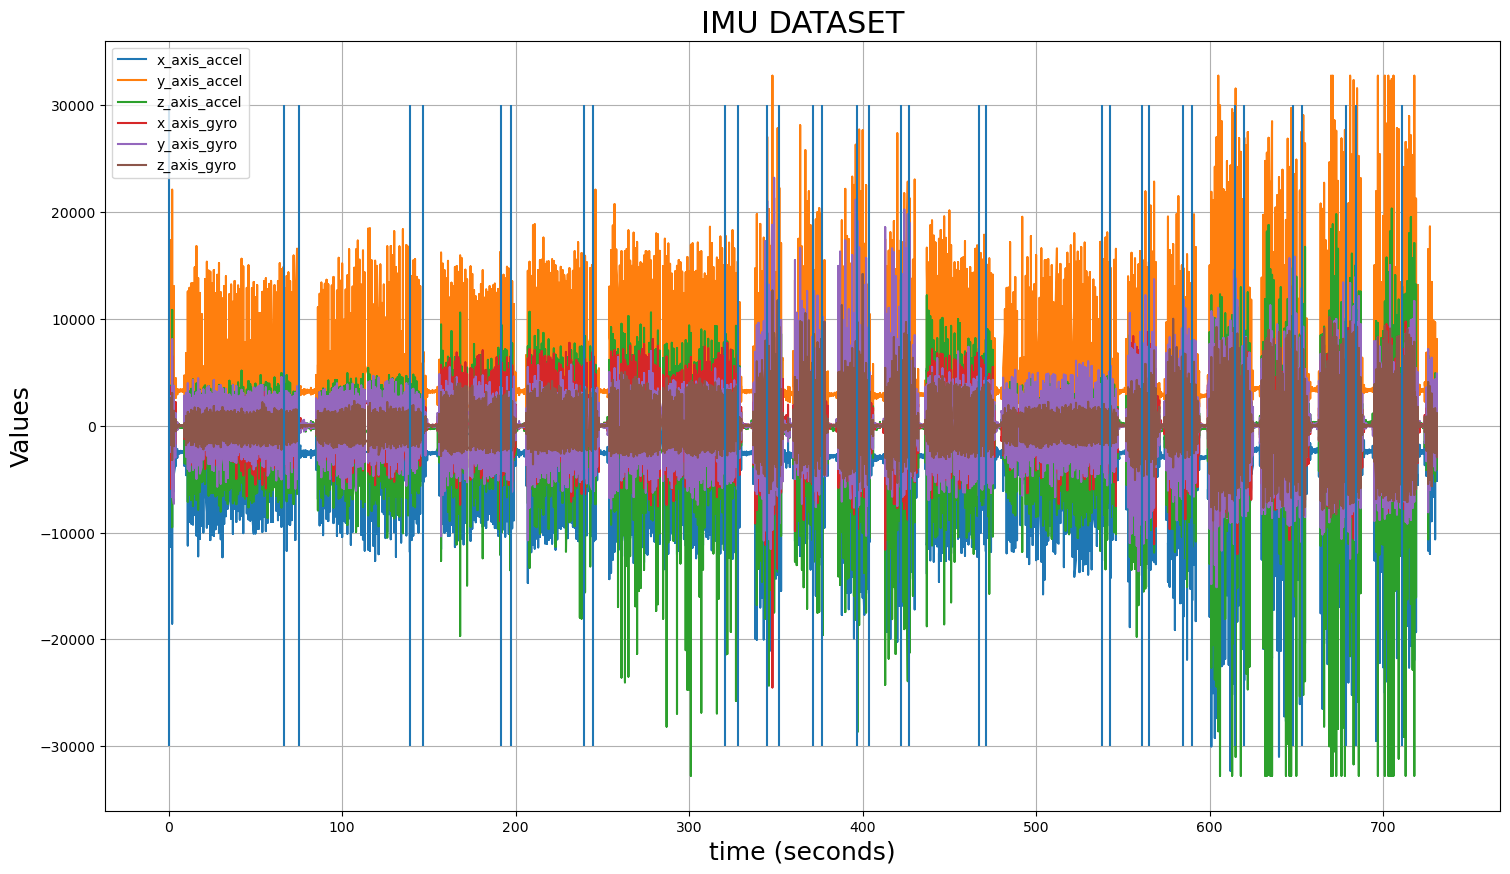

In [16]:
# Re-plot our IMU data and overlay the time points inthe activity dataset where the labels change
plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

# Add vertical lines for every activity change
plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

In [17]:
# Printing the first value of our labels series
activity_data_raw.label[0]

'Walking'

Ok, so from the above plot we can see that our data is not aligned, judging by the small gaps between the vertical lines, and the fact that the first activity label is walking,<br>
the small blip of imu data at the start needs to be removed and we need our imu dataset to start a little later where the first section of consistancy begins. This should <br>
solve the alignment problem of our datasets, we also need to remove the last section of the imu data after the last section of consistancy. To find what values we need to slice <br>
out, we can use some trial and error passing in sliced sections of our imu dataset to our plot function and finding the exact values we need. Afterwards we can reassign our data<br>
frame without the uneeded rows of data and then re-adjust the time series again.

## Align and combined the activity and imu datasets using the activity transitions

In [18]:
# Slice up our imu data to remove unwanted start and end data
imu_processed = imu_data_raw.drop(["time (seconds)"], axis=1)[900:70000]

# reset the inde on the dataframe and drop the old index column
imu_processed = imu_processed.reset_index().drop("index", axis=1)
imu_processed.head()

timestamp  x_axis_accel  y_axis_accel  z_axis_accel  x_axis_gyro  \
0  1598240222         -2602          2848         -3576         -413   
1  1598240222         -2850          2936         -3502         -315   
2  1598240222         -3172          2890         -3450         -248   
3  1598240222         -3340          2772         -3240         -236   
4  1598240222         -3346          2566         -3114         -287   

   y_axis_gyro  z_axis_gyro  
0          -51         -205  
1           -1         -123  
2          114          -17  
3          273           60  
4          469           83

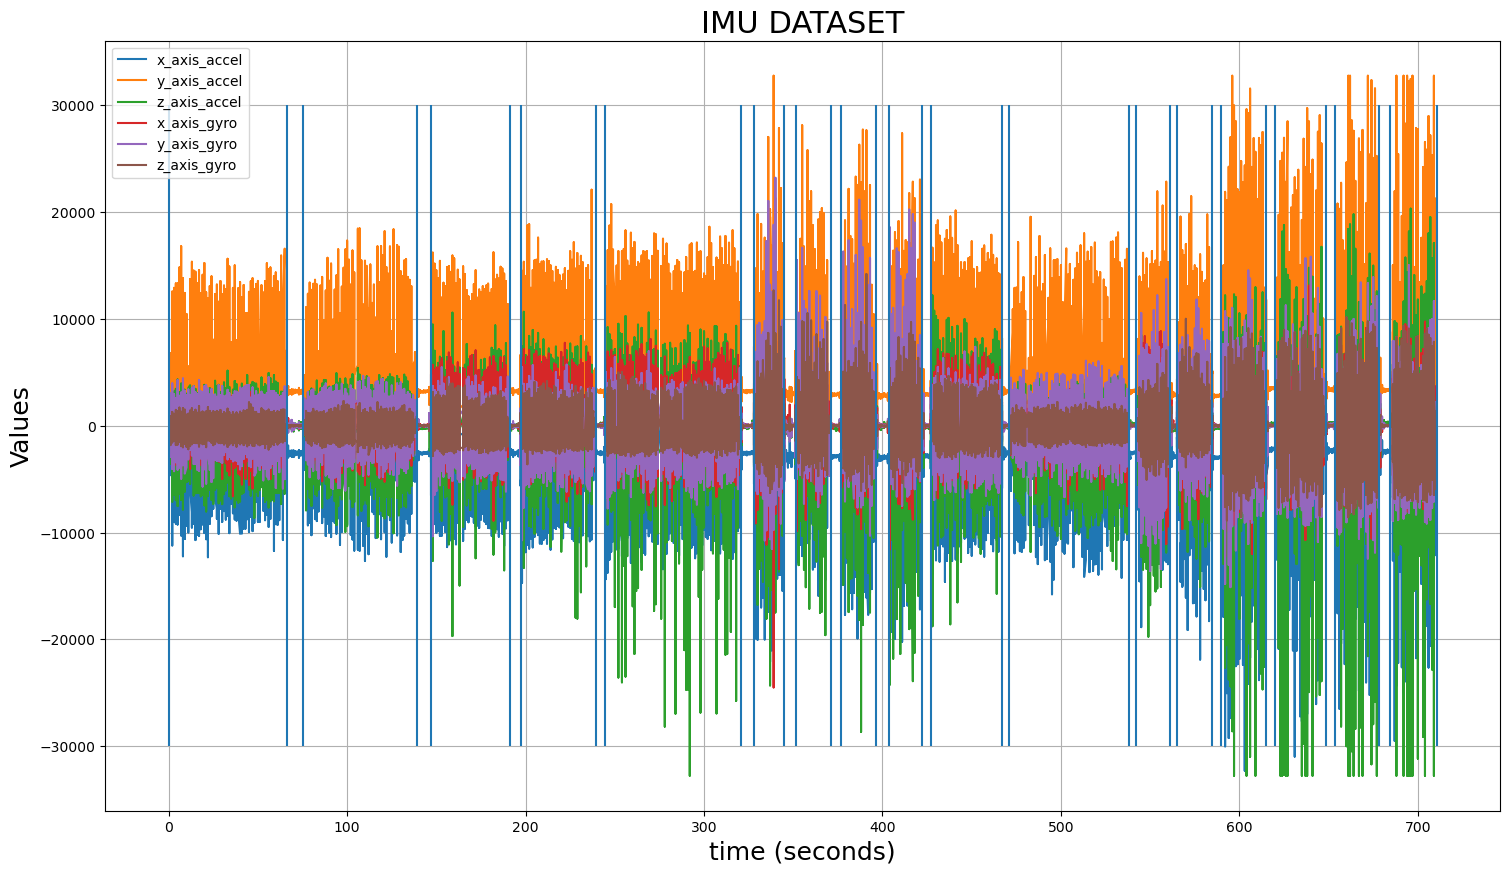

In [19]:
# Re-call the unix timestamp converter to re-adjust the time values
imu_processed["time (seconds)"] = convert_time_series(imu_processed["timestamp"])

plot_dataframe(imu_processed["time (seconds)"],  imu_processed.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

## Process the activity annotation data to assign a target activity to each data point within the IMU dataset.

In [20]:
# Setting an index for the activity label data row
index=1

# Creating a list to hold our activity labels
label=[]

# Iterating through every row of our imu dataset
for row in range(len(imu_processed)):

    # If the time for any given row in our imu data is less than the time in our activity data, we are appending the 
    # label from the activity data to our list of activity labels. Since the activity data's time starts at 0.00, this 
    # will throw our labels off by one row, so we minus 1 when appending to ensure we get the correct label assigned.
    if imu_processed["time (seconds)"][row] <= activity_data_raw.time[index]:
        label.append(activity_data_raw.label[index-1])
    # if the time for a given row from our imu data is greater then the current time in our activity data, we increment
    # the index by one, shifting our activity data to the next row, and continue to append whatever the activity label
    # is for that row to our activity list.
    else: 
        index +=1
        label.append(activity_data_raw.label[index-1])

# Create a new column in our imu dataset with our new labels which will be our targets for training.
imu_processed["label"] = label

# Sanity check to make sure all worked out
# for x in imu_processed["label"]:
#     print(x)
imu_processed.head()

timestamp  x_axis_accel  y_axis_accel  z_axis_accel  x_axis_gyro  \
0  1598240222         -2602          2848         -3576         -413   
1  1598240222         -2850          2936         -3502         -315   
2  1598240222         -3172          2890         -3450         -248   
3  1598240222         -3340          2772         -3240         -236   
4  1598240222         -3346          2566         -3114         -287   

   y_axis_gyro  z_axis_gyro  time (seconds)    label  
0          -51         -205               1  Walking  
1           -1         -123               1  Walking  
2          114          -17               1  Walking  
3          273           60               1  Walking  
4          469           83               1  Walking

So now we have our labels from our activity dataset appeneded to our imu dataset and everything is sliced up and aligned. We have time counted in seconds instead <br>
of unix timestamps, all we need to do before firing up our classifiers is to create some features from our data to train the classifiers on. This is what we will <br>
now turn our attention to in the next section.

## Calculate a set of features from the raw sensor data.

### Feature functions

#### Mean

In [21]:
# Function to calculate the mean for a series.

def calculate_mean(time_series, target_series, time_steps):
    """
    Calculates the mean of a pandas data series for a given period of time

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the mean on
    time_steps - The timeframe (i.e number of seconds) to calculate the mean over
    Returns:
    mean - A list of averages from the target_series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # list to hold the averages to be returned
    mean = []

    # iterate through every row of the dataframe
    for row in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the mean over
        if time_series[row] <= seconds:
            # add the rows data to the sum
            cumsum += target_series[row]
            # increment the divors by 1
            divisor += 1
        # otherwise if the above is not the case, then the next row of data's time has gone up
        # i.e we have reached the end of the calculatable period
        else:
            # safety net for divide by zero case
            if divisor != 0:
                # divide the total accumulated sum by the amount of entries, and append it to the list
                mean.append(round(cumsum/divisor, 6))
            else:
                # append 0 if there were no values, (we can deal with zero values later)
                mean.append(0)
            # Reset all of the variables for the next time step
            divisor = 0
            cumsum = 0
            cumsum += target_series[row]
            seconds += time_steps

    return mean

#### Max value

In [22]:
# Function to calculate the max values

def calculate_max(time_series, target_series, time_steps):
    """
    Calculates the max value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the max on
    time_steps - The timeframe (i.e number of seconds) to calculate the max over
    Returns:
    max_ls - A list of max values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    max = 0
    # list to hold the max values to be returned
    max_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target > max:
                max = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            max_ls.append(round(max, 6))
            seconds += time_steps
            max = target

    return max_ls

#### Min value

In [23]:
# Function to calculate the min values

def calculate_min(time_series, target_series, time_steps):
    """
    Calculates the min value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the min on
    time_steps - The timeframe (i.e number of seconds) to calculate the min over
    Returns:
    min_ls - A list of min values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    min = 0
    # list to hold the max values to be returned
    min_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target < min:
                min = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            min_ls.append(round(min, 6))
            seconds += time_steps
            min = target

    return min_ls

#### Signal Magnitude Area

In [24]:
# Function to calculate the signal magnitude area

def calculate_signal_magnitude_area(time_series, x, y, z, time_step):
    """
    Calculates the signal magnitude area of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for hte signal magnitude 
    y - An y series of data to be used for the signal magnitude 
    z - An z series of data to be used for the signal magnitude 
    time_steps - The timeframe (i.e number of seconds) to calculate the signal magnitude over
    Returns:
    sma - A list of signal magnitude values from the x, y, z, target series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_step
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # a list to hold all of the signal magnitude features
    sma = []

    # Iterates through all rows of the time series
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            # add the values of all three series to the cumulative total
            cumsum += x[i] + y[i] + z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0
            if divisor != 0:
                # multiply negative values by -1 to get the absolute value
                if cumsum < 0:
                    cumsum = cumsum * -1
                # divide the absolute value by the number of samples and append result to the list
                sma.append(round(cumsum/divisor, 6))
            else:
                # append 0 if the divisor was 0, ie no samples over the time period
                sma.append(0)
            # reset all the values for the time step
            cumsum = 0
            cumsum += x[i] + y[i] + z[i]
            seconds += time_step

    return sma

#### Average Intensity

In [25]:
def calculate_average_intensity(time_series, x, y, z, time_step):
    """
    Calculates the average intensity of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for the average intensity
    y - An y series of data to be used for the average intensity 
    z - An z series of data to be used for the average intensity
    time_steps - The timeframe (i.e number of seconds) to calculate the average intensity over
    Returns:
    ai - A list of average intensity values from the x, y, z, target series calculated over the given time_steps. 
    """
    seconds = time_step
    xsum, ysum, zsum = 0, 0, 0

    divisor = 0
    # list to hold the average intensity values
    ai = []
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            
            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0, square the values
            if divisor != 0:
                xsum = xsum**2
                ysum = ysum**2
                zsum = zsum**2

                # TAKE THE SQUARE ROOOOT
                sqrt = math.sqrt(xsum+ysum+zsum)

                # divide the value by the amount of samples and add it to the list
                ai.append(round(sqrt/divisor, 6))
            else:
                # Append 0 if the divisor is 0, i.e there were no samples
                ai.append(0)
            # Reset all the values for the next time_step
            xsum, ysum, zsum = 0, 0, 0

            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            seconds += time_step
    return ai

#### Acitivity Labels

In [26]:
# Function for activity labels

def assign_labels(time_series, target_series, time_steps):
    """
    Assigns the activity value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of our activity values to assign 
    time_steps - The timeframe (i.e number of seconds) to calculate which activity is being performed
    Returns:
    Activity - A list of activity values from the target_series calculated over the given time_steps. 
    
    """
    
    seconds = time_steps

    activity = []
    # Iterate through all rows of the dataframe and assign a target activity label for each time step
    for row in range(len(time_series)):
        # similiar to the features functions above, if the current row of the time series has the same
        # value of time as the time_step, then continue to the next row
        if time_series[row] <= seconds: continue
        # if the value in the time series is now greater then the current time_step, then append the last
        # activity to the list, this will be the label for that time_step
        else:
            # Assign the last label to the list
            activity.append(target_series[row-1])
            seconds += time_steps
    return activity

### Create a new Dataframe made of our new features

In [27]:
# Create a new dataframe to hold all of our features
imu_features = pd.DataFrame()

# Set a time step to calculate all features over, this is the amount of seconds that each feature should be calculated 
# over, be warned, when increasing this number it doesn't take long for the accuracy of the features to drop 
# dramatically as you are calculating over longer time periods with activity changes.
time_steps = 1

# time series of values
time_series = imu_processed["time (seconds)"]

# Mean features
imu_features["x_accel_mean"] = calculate_mean(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_mean"] = calculate_mean(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_mean"] = calculate_mean(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_mean"] = calculate_mean(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_mean"] = calculate_mean(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_mean"] = calculate_mean(time_series, imu_processed["z_axis_gyro"], time_steps)

# max features
imu_features["x_accel_max"] = calculate_max(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_max"] = calculate_max(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_max"] = calculate_max(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_max"] = calculate_max(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_max"] = calculate_max(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_max"] = calculate_max(time_series, imu_processed["z_axis_gyro"], time_steps)

# min features
imu_features["x_accel_min"] = calculate_min(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_min"] = calculate_min(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_min"] = calculate_min(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_min"] = calculate_min(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_min"] = calculate_min(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_min"] = calculate_min(time_series, imu_processed["z_axis_gyro"], time_steps)

# Signal magnitude area
imu_features["sma_accel"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["sma_gyro"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# average intensity
imu_features["ai_accel"] = calculate_average_intensity(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["ai_gyro"] = calculate_average_intensity(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# Label feature
imu_features["target"] = assign_labels(time_series, imu_processed["label"], time_steps)

# # Finally add time in seconds to our new dataframe
time = []
steps = 1
# iterate through all row of activites and append a value of time
for row in range(len(imu_features)):
    time.append(steps)
    steps += 1

# add the list to the features dataframe 
imu_features["time"] = time


### Plotting our Features along with the activity markers

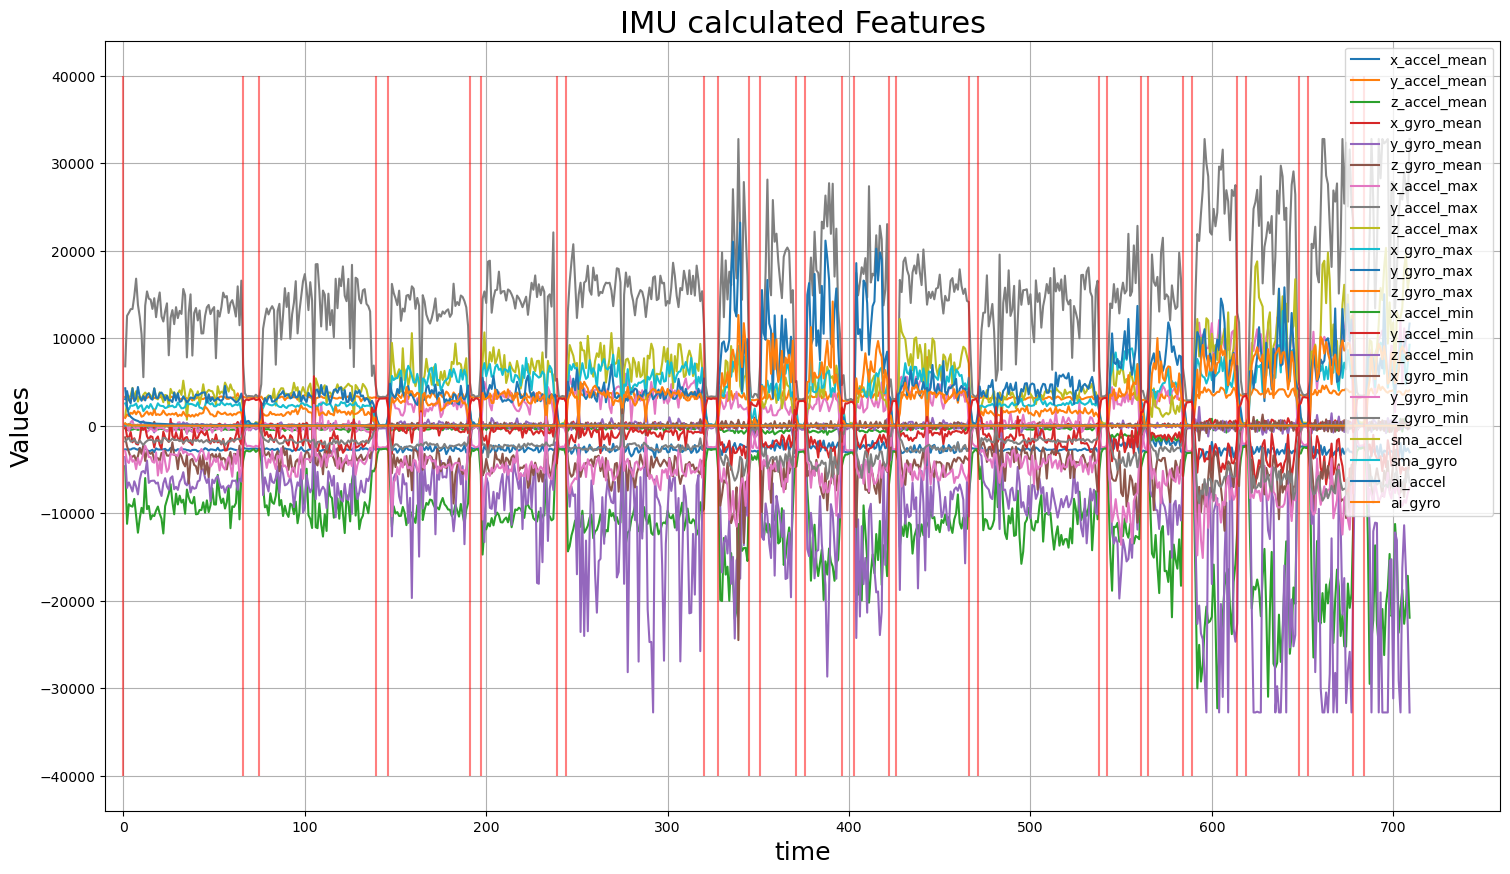

In [28]:
# Since the time steps can change depending on if we want 1, 2, 3, etc second itervals to calculate
# our features over, we have to make sure the activity transitions move with the time steps, below
# is a loop that creates a list of activity transitions depending on the value in the data series
activity_markers = [0]
# Set a variable to keep track of the current activity we are up to
current_label = imu_features["target"][0]
# iterate through all rows of the target labels, ie "walking", "jogging", etc
for row in range(len(imu_features["target"])):
    # if the current activity isnt the same as the target row, append the value to the list and 
    
    if current_label != imu_features["target"][row]:
        activity_markers.append(row)
        # change the current activity to the freshly added value to our list
        current_label = imu_features["target"][row]

# plot the new dataframe with the calculated features and add the vertical lines from the activity series to check it lines up
plot_dataframe(imu_features["time"], imu_features.drop(["target", "time"], axis=1), "IMU calculated Features")

# Plot the vertical lines associated with our activity transitions
plt.vlines(activity_markers, -40000,40000, color="r", alpha=0.5)
plt.xlim(-10, len(imu_features) + 50)
plt.show()

Ok so from the above plot we can now see that we were successfully able to transform our data from raw values into a set of features to be used <br>
for classfication. We chose to use the mean, max, min, signal magnitude, and average intensity values for each axis. Now onwards to training our<br>
classifiers!


# Andrew Lu

## Apply a machine learning workflow to train classifiers

In [29]:
# Our data set is now called imu_features, run some of the basic pandas functions on it to get an idea of what
# we are working with and what everything looks like, ask me any questions you need to about anything, or if 
# you need any help at all, im here to help.
imu_features.head()

x_accel_mean  y_accel_mean  z_accel_mean  x_gyro_mean  y_gyro_mean  \
0  -2703.360000   3299.400000   -318.740000   188.040000  -120.140000   
1  -2733.737374   3318.101010   -485.373737    25.141414  -205.969697   
2  -2708.755556   3033.000000   -469.800000  -264.022222  -476.966667   
3  -2720.536082   3024.783505   -473.092784  -190.546392  -331.020619   
4  -2602.424242   3157.797980   -434.949495   -56.757576   -96.606061   

   z_gyro_mean  x_accel_max  y_accel_max  z_accel_max  x_gyro_max  ...  \
0   -54.690000            0         6784          994        2548  ...   
1    42.070707           32        12562         2822        2076  ...   
2   122.222222         -592        12910         3198        1857  ...   
3   -48.762887          394        13320         3450        2331  ...   
4   -65.707071          596        13342         4324        2275  ...   

   z_accel_min  x_gyro_min  y_gyro_min  z_gyro_min   sma_accel    sma_gyro  \
0        -3576       -1334       -2889       -1814  277.300000   13.210000   
1        -7110       -2361       -4045       -1564   49.246231   69.030151   
2        -6478       -3004       -4256       -1381   45.328720  192.695502   
3        -6962       -3631       -3419       -1808   42.430052  143.321244   
4        -7520       -3540       -4117       -1762   24.581443   44.717526   

      ai_accel     ai_gyro   target  time  
0  4277.357927  229.746942  Walking     1  
1  2152.385132  105.328267  Walking     2  
2  1274.808190  173.988927  Walking     3  
3  1029.220804   96.760256  Walking     4  
4   839.975424   26.513755  Walking     5  

[5 rows x 24 columns]

### Encoding, Splitting and Scaling Our Data

In [78]:
# Dropping the target and time columns from the feature set
X = imu_features.drop(columns=["target", "time"])
y = imu_features["target"]

#Converting the string labels(e.g Walking, Running) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#Scaling the features, allowing the input data to be normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training Our Classifiers

### Knn classifier

In [79]:
#K-Nearest Neighbors classifier
#n_neighbours = 5, the model will consider 5 data points nearby
knn_classifier = KNeighborsClassifier(n_neighbors=5)

#Fitting the classifier into the training data
knn_classifier.fit(X_train, y_train)

#Predicting the labels for the test set using the classifier
y_pred_knn = knn_classifier.predict(X_test)

### Decision Trees

In [80]:
#Decision tree classifier, no max depth and random state of 42 to ensure the results are reproducible 
decision_tree = DecisionTreeClassifier(max_depth = None , random_state=42)

#Fitting the classifier into the training data
decision_tree.fit(X_train, y_train)

#Predicting the labels for the test set using the classifier
y_pred_tree = decision_tree.predict(X_test)

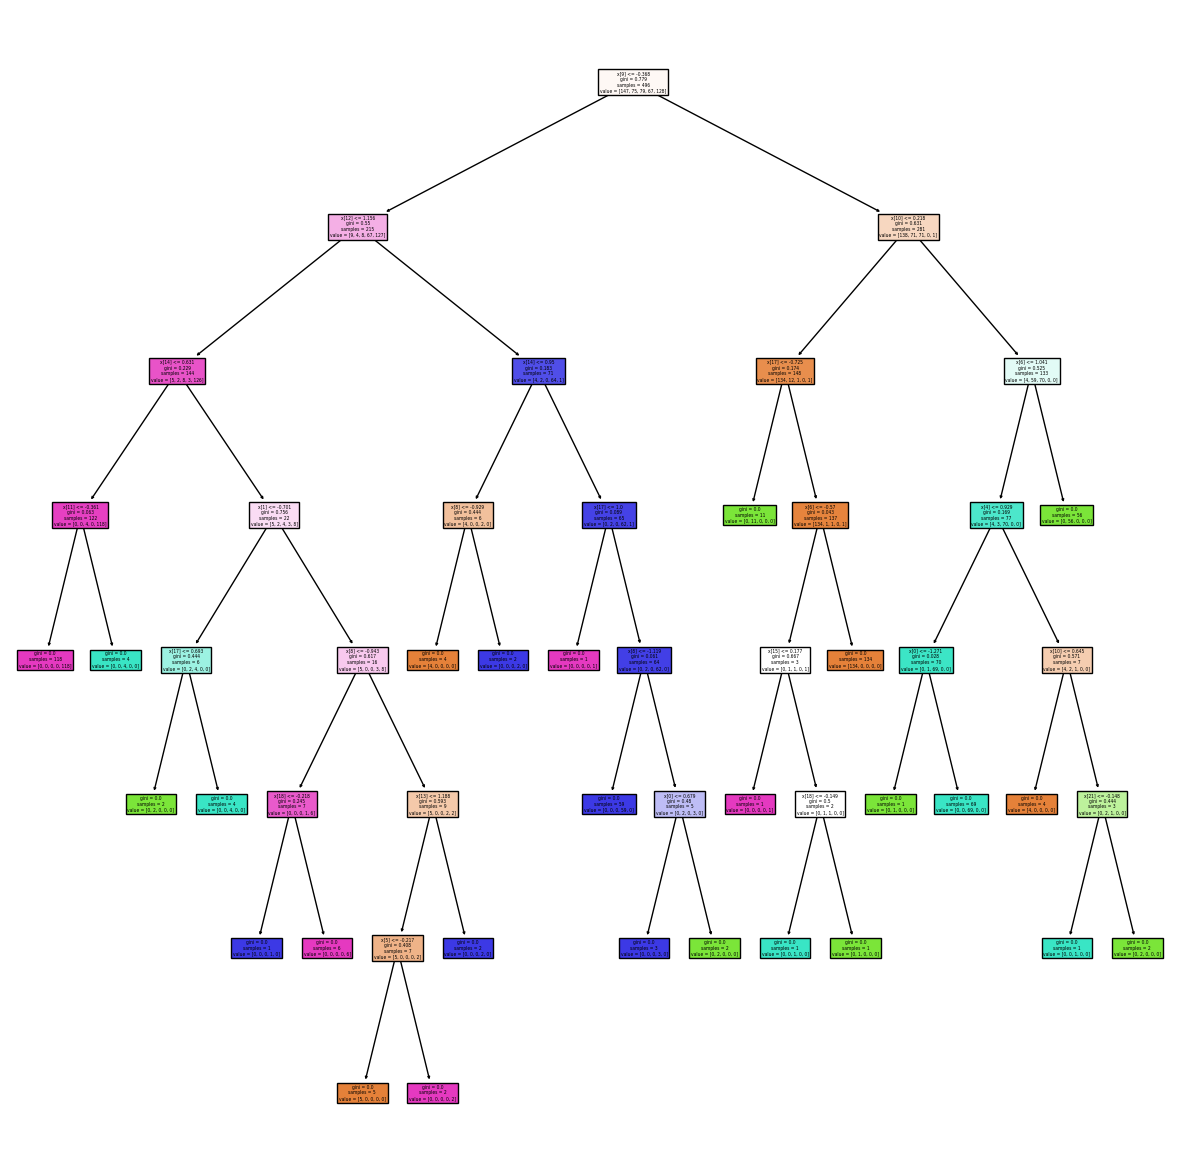

In [81]:
#Visualizing the decision tree classifier
plt.figure(figsize = (15, 15))
plot_tree(decision_tree, filled=True)
plt.show()

### SGD Classifier

In [82]:
# Stochastic Gradient Descent (SGD) Classifier
sgdc = SGDClassifier(random_state=42)

# Fit the SGD classifier to the training data
sgdc.fit(X_train, y_train)

# Predict the labels for the test set using the trained SGD classifier
y_pred_sgdc = sgdc.predict(X_test)


### RandomForest Classifier

In [83]:
# Random Forest Classifier, n_estimators(the number of trees in the forest)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set using the trained Random Forest classifier
y_pred_rf = rf_classifier.predict(X_test)

## Performance Metrics for classifiers

### Best Feature Selection

In [84]:
# Encode the categorical labels into numeric form using LabelEncoder
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# Define the classifiers we want to test
classifiers = {
    'SGDC' : sgdc,
    'KNN' : knn_classifier,   
}

# Determine the number of features in the dataset
num_features = X_train.shape[1]

# Loop through each classifier in the classifiers dictionary
for name, clf in classifiers.items():
    print(f"{name} Feature Selection:\n")

    #Storing the best results 
    best_mean_f1 = 0
    best_f1 = 0
    best_f2 = 0

    ##Testing every combination of pairs of features
    for f1 in range(num_features):
        for f2 in range(num_features):

            if f1 == f2:
                continue
            features_idx_to_use = [f1, f2]

            # Select the two features 
            X_train_selected = X_train[:, features_idx_to_use]

            # EDIT - we don't need to do anything with the X_test set yet, so this is not needed
            # X_test_selected = X_test[:, features_idx_to_use]

            # Train the classifier
            # EDIT - removed y_train_encoded and replaced with y_train
            clf.fit(X_train_selected, y_train)
            y_predicted = cross_val_predict(clf, X_train_selected, y_train, cv=3)

            # Calculate the F1 score
            current_f1 = np.mean(f1_score(y_train, y_predicted, average='macro'))

            # Print out the F1 score
            # print(f"First Feature: {f1} Second Feature: {f2} F1 score: {current_f1:.6f}")

            # Update the best feature combination
            if current_f1 > best_mean_f1:
                best_f1 = f1
                best_f2 = f2
                best_mean_f1 = current_f1

                # EDIT - Print only features that score higher F1, cleans up the visualization of the training
                # to a more palettable size
                print(f"First Feature: {best_f1}\t Second Feature: {best_f2}\t F1 score: {current_f1:.6f}")
    
    # Print the best result for this classifier
    print(f"\nBest Features for {name}: First Feature: {best_f1}, Second Feature: {best_f2} with F1 Score: {best_mean_f1:.6f}\n")
    

SGDC Feature Selection:

First Feature: 0	 Second Feature: 1	 F1 score: 0.316106
First Feature: 0	 Second Feature: 2	 F1 score: 0.392664
First Feature: 0	 Second Feature: 6	 F1 score: 0.597761
First Feature: 0	 Second Feature: 11	 F1 score: 0.626135
First Feature: 0	 Second Feature: 17	 F1 score: 0.700921
First Feature: 6	 Second Feature: 10	 F1 score: 0.722666
First Feature: 6	 Second Feature: 11	 F1 score: 0.753180

Best Features for SGDC: First Feature: 6, Second Feature: 11 with F1 Score: 0.753180

KNN Feature Selection:

First Feature: 0	 Second Feature: 1	 F1 score: 0.644934
First Feature: 0	 Second Feature: 6	 F1 score: 0.833732
First Feature: 0	 Second Feature: 17	 F1 score: 0.844711
First Feature: 2	 Second Feature: 11	 F1 score: 0.855804
First Feature: 2	 Second Feature: 17	 F1 score: 0.868746
First Feature: 6	 Second Feature: 10	 F1 score: 0.888159

Best Features for KNN: First Feature: 6, Second Feature: 10 with F1 Score: 0.888159



### Retrain Knn an SGD Classifier's on their best Features

In [93]:
# Retrain the Knn with the best features found above

# Retrain the SGD with the best features found above



### Confusion Matrix comparison

In [90]:
# Calculate the confusion matrix for each classifier
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_sgdc = confusion_matrix(y_test, y_pred_sgdc)
cm_rf = confusion_matrix(y_test, y_pred_rf)

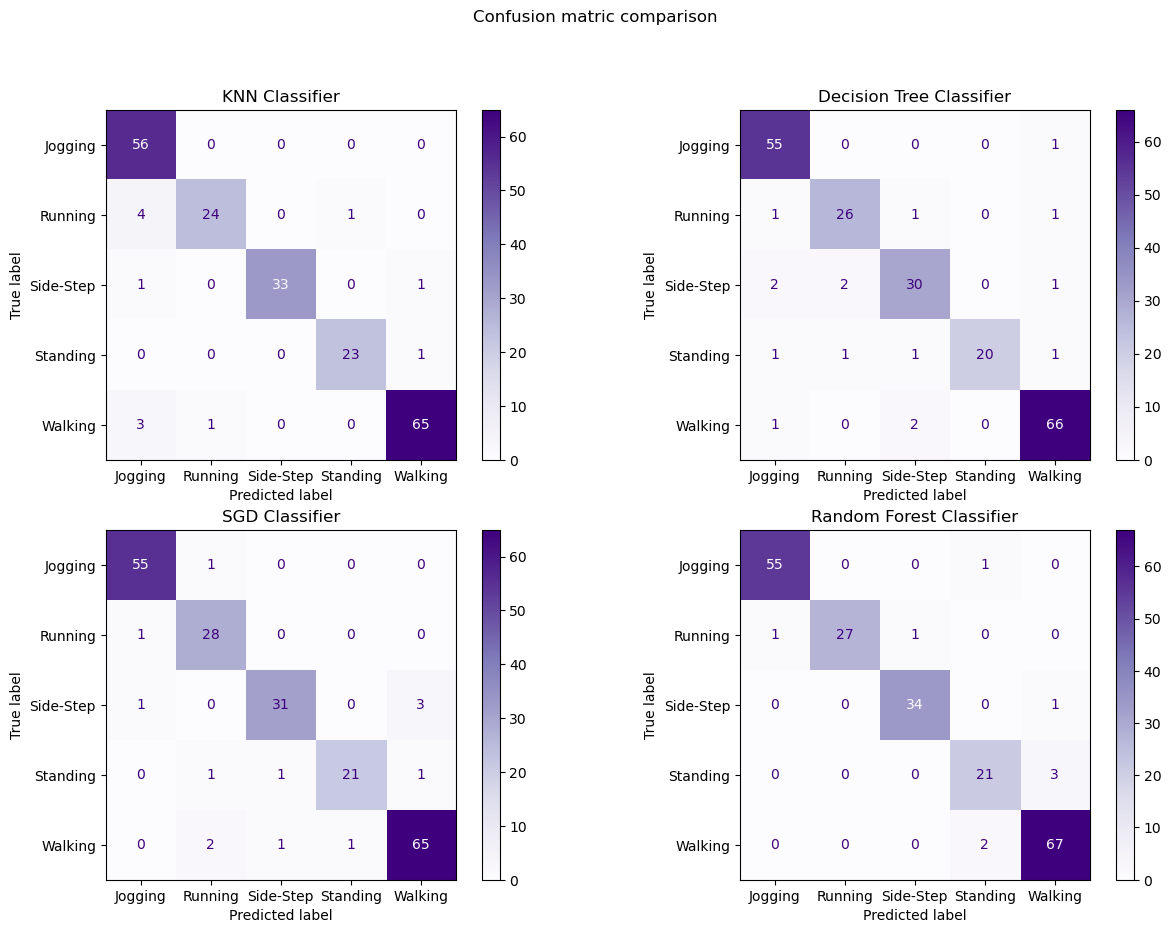

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get unique class labels to display on the confusion matrix
# class_labels = y_test.unique()
# EDIT - We can use the label_encoder you trained up there, and call the .classes_ method to get the label names
# this keeps track of our y value labels and also if we pick two features for our classifiers this won't cause
# an error when calculating the confusion matrix's, you can test unique() again to see if you want.
class_labels = label_encoder.classes_

##Displays for each of the classifers
display_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=class_labels)
display_knn.plot(ax=axes[0, 0], cmap=plt.cm.Purples)
axes[0, 0].set_title("KNN Classifier")

display_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=class_labels)
display_tree.plot(ax=axes[0, 1], cmap=plt.cm.Purples)
axes[0, 1].set_title("Decision Tree Classifier")

display_sgdc = ConfusionMatrixDisplay(confusion_matrix=cm_sgdc, display_labels=class_labels)
display_sgdc.plot(ax=axes[1, 0], cmap=plt.cm.Purples)
axes[1, 0].set_title("SGD Classifier")

display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_labels)
display_rf.plot(ax=axes[1, 1], cmap=plt.cm.Purples)
axes[1, 1].set_title("Random Forest Classifier")

plt.suptitle("Confusion matric comparison")
plt.show()

In [92]:
def performance_metrics(classifiers, X_train, y_train, X_test, y_test):

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)  #Training the classifier
        y_pred = clf.predict(X_test)  #Predicting on the test set

        #Calculating the metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        #Printing the results
        print(f"Classifier: {name}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print('\n')

#Define classifiers
classifiers = {
    'SGDC' : sgdc,
    'RF' : rf_classifier,
    'KNN' : knn_classifier,
    'dTREE' : decision_tree
}

#Call the performance_metrics function with the classifiers
performance_metrics(classifiers, X_train, y_train, X_test, y_test)

Classifier: SGDC
Accuracy: 0.9389671361502347
Precision: 0.935176132029679
Recall: 0.9300806739487399
F1 Score: 0.9316642567938687


Classifier: RF
Accuracy: 0.9577464788732394
Precision: 0.9544466800804828
Recall: 0.9461240808167345
F1 Score: 0.95


Classifier: KNN
Accuracy: 0.9436619718309859
Precision: 0.9526965174129354
Recall: 0.9341611337188549
F1 Score: 0.94140522875817


Classifier: dTREE
Accuracy: 0.9248826291079812
Precision: 0.9276856949676422
Recall: 0.9051385021774827
F1 Score: 0.9146248000917788




# Jessica Vu

### Create visualizations for how the classifiers learnt (Feel free to change all of this)

## Re-Training our classifiers with hyper-parameter optimization (Feel free to change any of the below sections)

#### Performance metrics for re-trained Classifiers

### Create visualizations for how the classifiers re-learnt 

# Summary

## Conclude and summerise what we learnt